In [35]:
%load_ext autoreload
%autoreload 2

In [36]:
import re
import os
import wandb
import string
import numpy as np
import unicodedata
import pandas as pd
from pathlib import Path
from datasets import load_dataset
from collections import defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import flash_attn
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import EarlyStoppingCallback
from transformers import AutoTokenizer, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

import sys
sys.path.append("../../src")
import util.preprocessing_util as util

# Setup

Check versions of important packages

In [37]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("Flash Attention version:", flash_attn.__version__)

PyTorch version: 2.6.0+cu124
CUDA version: 12.4
Flash Attention version: 2.7.4.post1


Check which python we are using

In [38]:
print(sys.executable)

/share/miniforge3/bin/python3.10


REMOVE BEFORE PUSHING OR MAKING PUBLIC IN ANY FORM !!!

In [39]:
hg_token = ""

# Load Data

In [40]:
input_data_path = Path("../../data/dev/processed")

In [41]:
train_df = pd.read_csv(input_data_path / "pubmedqa_train.csv")
test_df = pd.read_csv(input_data_path / "pubmedqa_test.csv")

Sentences and labels are still stringified lists --> back to actual Python lists

In [42]:
import ast

# Apply literal_eval to parse strings into actual lists
train_df["sentences"] = train_df["sentences"].apply(ast.literal_eval)
train_df["labels"] = train_df["labels"].apply(ast.literal_eval)

test_df["sentences"] = test_df["sentences"].apply(ast.literal_eval)
test_df["labels"] = test_df["labels"].apply(ast.literal_eval)

In [43]:
train_df.head()

,question,sentences,labels
0,is there a functional neural correlate of indi...,[the present study tested whether individuals ...,"[1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0]"
1,can we use the omron t9p automated blood press...,[recent events in our hospital combined with i...,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, ..."
2,intraabdominal vascular injury are we getting ...,[intraabdominal vascular injury iavi as a resu...,"[1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, ..."
3,hand grip and pinch strength in patients with ...,[the hand grip strength test and pinch was sig...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, ..."
4,is canada ready for patient accessible electro...,[access to personal health information through...,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, ..."


# Masking

**Mask Sentences**

- Replace all sentences except one with a [MASK] token
- Keep only one sentence unmasked at a time

In [44]:
WINDOW_SIZE = -1

In [45]:
def mask_sentences(sentences, target_idx):
    """
    Masks all sentences except the one at target_idx.
    """
    return " ".join(
        [sent if idx == target_idx else "[MASK]" for idx, (sid, sent) in enumerate(sentences)]
    )

In [46]:
def create_masked_inputs(df):
    masked_data = []

    for _, row in df.iterrows():
        question = row["question"]
        sentences = row["sentences"]
        labels = row["labels"]

        for i, sentence in enumerate(sentences):
            # Mask all sentences except the one at index i
            masked_context = ["[MASK]" if j != i else s for j, s in enumerate(sentences)]
            full_context = " ".join(masked_context)

            # Store new training instance
            masked_data.append({"question": question, "context": full_context, "label": labels[i]})

    return pd.DataFrame(masked_data)

In [47]:
masked_train_df = create_masked_inputs(train_df)
masked_test_df = create_masked_inputs(test_df)

In [48]:
masked_train_df.head()

,question,context,label
0,is there a functional neural correlate of indi...,the present study tested whether individuals w...,1
1,is there a functional neural correlate of indi...,[MASK] this study examined whether heightened ...,0
2,is there a functional neural correlate of indi...,[MASK] [MASK] heart rate variability hrv a mea...,0
3,is there a functional neural correlate of indi...,[MASK] [MASK] [MASK] previous studies have als...,0
4,is there a functional neural correlate of indi...,[MASK] [MASK] [MASK] [MASK] low socioeconomic ...,0


# Training End-To-End

Important Configs

In [53]:
MODEL = "answerdotai/ModernBERT-base"
CONTEXT_LENGTH = 512
BATCH_SIZE = 64

In [54]:
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base", token=hg_token)

Load ModernBERT Model (Trainable Embeddings)

In [55]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL, num_labels=2, token=hg_token, attn_implementation="flash_attention_2"
)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Check if model parameters are trainable (Ensure We Are Training End-to-End)

In [56]:
for param in model.parameters():
    param.requires_grad = True  # Ensure the entire model is updated

Prepare the dataset

In [57]:
dataset_train = Dataset.from_pandas(masked_train_df)
dataset_test = Dataset.from_pandas(masked_test_df)

In [58]:
progress_bar = tqdm(total=((len(dataset_train)+len(dataset_test))),
                    desc="Tokenizing", position=0, leave=True)

Tokenizing:   0%|          | 0/267410 [00:00<?, ?it/s]

In [59]:
def tokenize_batch(batch):
    encodings = tokenizer(
        batch["question"],
        batch["context"],
        padding="max_length",
        truncation=True,
        max_length=CONTEXT_LENGTH,
        return_tensors="pt"
    )
    return {
        "input_ids": encodings["input_ids"].tolist(),
        "attention_mask": encodings["attention_mask"].tolist(),
        "labels": batch["label"]
    }

def tokenize_with_progress(batch):
    out = tokenize_batch(batch)
    progress_bar.update(len(batch["question"]))
    return out

In [60]:
tokenized_dataset_train = dataset_train.map(tokenize_with_progress, batched=True, batch_size=BATCH_SIZE)
tokenized_dataset_test = dataset_test.map(tokenize_with_progress, batched=True, batch_size=BATCH_SIZE)

Map:   0%|          | 0/237544 [00:00<?, ? examples/s]

Map:   0%|          | 0/29866 [00:00<?, ? examples/s]

In [61]:
progress_bar.close()

Convert to PyTorch Dataset (Ensure dataset is set to PyTorch format)

In [62]:
tokenized_dataset_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_dataset_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Create DataLoader for Batching

In [63]:
train_dataloader = DataLoader(tokenized_dataset_train, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(tokenized_dataset_test, batch_size=BATCH_SIZE)

# Check one batch
batch = next(iter(train_dataloader))
print({key: value.shape for key, value in batch.items()})

{'input_ids': torch.Size([64, 512]), 'attention_mask': torch.Size([64, 512]), 'labels': torch.Size([64])}


Quick check if everything is correct before training

In [64]:
print("----- Training Set -----")
print(tokenized_dataset_train)
print(tokenized_dataset_train.column_names)
print("----- Test Set -----")
print(tokenized_dataset_test)
print(tokenized_dataset_test.column_names)

----- Training Set -----
Dataset({
    features: ['question', 'context', 'label', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 237544
})
['question', 'context', 'label', 'input_ids', 'attention_mask', 'labels']
----- Test Set -----
Dataset({
    features: ['question', 'context', 'label', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 29866
})
['question', 'context', 'label', 'input_ids', 'attention_mask', 'labels']


In [65]:
output_dir = Path("../../checkpoints")
output_dir.mkdir(parents=True, exist_ok=True)

# Training Configurations

Define training arguments & initialize trainer

In [66]:
NUM_EPOCHS = 3
BATCH_SIZE = 64
LEARNING_RATE = 2e-5
DATASET_NAME = "pubmedqa"

WANDB_PROJECT_NAME = "RAGBENCH-PUBMED"
WANDB_RUN_NAME = f"Mo-RUN01"
WANDB_NOTEBOOK_NAME = "train_sc_on_pubmed"

Setup W&B

In [67]:
os.environ["WANDB_NOTEBOOK_NAME"] = "train_sc_with_MASK.ipynb"
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: flackojodye (asap) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [68]:
config = dict(
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    dataset=DATASET_NAME,
    architecture=MODEL,
    window_size=WINDOW_SIZE,
    early_stopping=True,
    eval_steps=500,
    label_smoothing_factor=0.0,
    gradient_clipping=1.0,
    load_best_model=True,
    metric_for_best_model="f1",
    input_format="question + context with naive [MASK]"
)


Generate run-id to resume same run after training 

In [69]:
run_id = wandb.util.generate_id()

In [70]:
wandb.init(
    project=WANDB_PROJECT_NAME,
    name=WANDB_RUN_NAME,
    config=config,
    id=run_id,
    resume="allow"               # resume if it exists, else start new
)

In [71]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions),
        "precision": precision_score(labels, predictions),
        "recall": recall_score(labels, predictions),
    }

In [72]:
training_args = TrainingArguments(
    output_dir=output_dir,                        # Where model checkpoints will be saved
    run_name=WANDB_RUN_NAME,                      # Name for W&B tracking
    learning_rate=LEARNING_RATE,                  # Base learning rate
    per_device_train_batch_size=BATCH_SIZE,       # Training batch size
    per_device_eval_batch_size=(2 * BATCH_SIZE),  # Larger eval batch size to speed up
    num_train_epochs=NUM_EPOCHS,                  # Total training epochs
    weight_decay=0.01,                            # L2 regularization
    
    # Evaluation and saving settings
    evaluation_strategy="steps",                  # Evaluate every N steps
    eval_steps=500,                               # Eval frequency
    save_strategy="steps",                        # Save checkpoints every N steps
    save_steps=500,
    
    # Logging
    logging_dir="./logs",                         # Log folder
    logging_strategy="steps",
    logging_steps=250,
    report_to="wandb",                            # Log to Weights & Biases

    # Smart checkpointing
    load_best_model_at_end=True,                  # Load the best model after training
    metric_for_best_model="f1",                   # Focus on F1 (False positives and false negatives both matter)
    greater_is_better=True,                       # Higher F1 is better

    # Optimization tweaks
    gradient_accumulation_steps=1,                # For effective batch size
    label_smoothing_factor=0.0,                   # Helps generalization for classification
    fp16=True,                                    # Mixed precision for faster training (if supported)
    gradient_checkpointing=True,                  # Reduce memory usage during training
    max_grad_norm=1.0                             # Clip gradients to avoid instability
)



trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_train,
    eval_dataset=tokenized_dataset_test,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=4)] # Prevent overfitting by stopping when eval loss stops improving
)

/home/paul.schmitt/.local/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Make sure we are using the GPU

In [73]:
print("GPU Available:", torch.cuda.is_available())  
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

GPU Available: True
GPU Name: NVIDIA A40


In [74]:
model.to("cuda");

In [75]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.559600,0.614708,0.684792,0.657324,0.590710,0.740871
1000,0.522900,0.623815,0.686332,0.673998,0.585171,0.794617
1500,0.511300,0.611455,0.696712,0.685988,0.593913,0.811849
2000,0.498900,0.601662,0.701667,0.681125,0.603999,0.780832
2500,0.478600,0.634628,0.692259,0.687901,0.586780,0.831132
3000,0.463800,0.624267,0.698051,0.691249,0.593091,0.828342
3500,0.453500,0.628199,0.702337,0.692409,0.598624,0.821039
4000,0.364500,0.684492,0.698888,0.690249,0.594800,0.822188
4500,0.370700,0.675069,0.705853,0.688110,0.606446,0.795192
5000,0.362800,0.688946,0.698687,0.684522,0.597564,0.801100


TrainOutput(global_step=5500, training_loss=0.4576380670720881, metrics={'train_runtime': 862.5272, 'train_samples_per_second': 826.214, 'train_steps_per_second': 12.911, 'total_flos': 1.1993858360932762e+17, 'train_loss': 0.4576380670720881, 'epoch': 1.4816810344827587})

Save the model (optional)

In [63]:
models_dir = Path("../../models/")
models_dir.mkdir(parents=True, exist_ok=True)

In [64]:
model.save_pretrained(models_dir)
tokenizer.save_pretrained(models_dir)

('../../models/tokenizer_config.json',
 '../../models/special_tokens_map.json',
 '../../models/tokenizer.json')

**Check Results**

Initialize this one more time because wandb closes automatically after training

In [76]:
run = wandb.init(
    project=WANDB_PROJECT_NAME,
    id=run_id,
    resume="must"  # must resume, or error if run doesn't exist
)

eval/accuracy,▁▁▅▆▃▅▆▅▇▅█
eval/f1,▁▄▇▆▇███▇▆▇
eval/loss,▂▃▂▁▄▃▃█▇█▄
eval/precision,▃▁▄▆▁▃▅▄▇▅█
eval/recall,▁▅▇▄██▇▇▅▆▅
eval/runtime,█▁▁▁▁▁▁▂▁▃▂
eval/samples_per_second,▁██████▆█▆▇
eval/steps_per_second,▁██████▆█▆▇
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
train/grad_norm,▂▃█▂▃▂▃▂▂▁▁▂▃▁█▄▅▄▃▂▅▆


In [77]:
results = trainer.evaluate()
df_results = pd.DataFrame([results])

In [78]:
label_names = ["Not Relevant", "Essential"]

In [79]:
df_results

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.628199,0.702337,0.692409,0.598624,0.821039,12.7619,2340.243,18.336,1.481681


**Classification Report**

In [80]:
predictions = trainer.predict(tokenized_dataset_test)
preds = predictions.predictions.argmax(axis=-1)
labels = predictions.label_ids
report = pd.DataFrame(classification_report(labels, preds, output_dict=True)).transpose()
display(report)

,precision,recall,f1-score,support
0,0.834157,0.620510,0.711645,17679.000000
1,0.598624,0.821039,0.692409,12187.000000
accuracy,0.702337,0.702337,0.702337,0.702337
macro avg,0.716391,0.720775,0.702027,29866.000000
weighted avg,0.738046,0.702337,0.703795,29866.000000


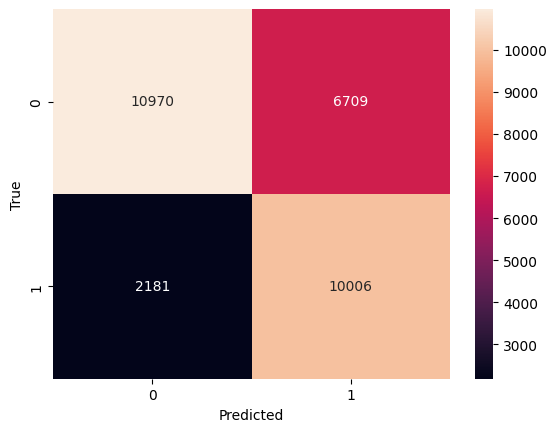

In [81]:
cm = confusion_matrix(predictions.label_ids, preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Persist Results**

In [101]:
eval_results_dir = f"./results/{WANDB_RUN_NAME}"
os.makedirs(eval_results_dir, exist_ok=True)

Locally

In [102]:
report.to_csv(os.path.join(eval_results_dir, "classification_report.csv"))

# Save Confusion Matrix 
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(os.path.join(eval_results_dir, "confusion_matrix.png"))
plt.close()

To Wandb

In [84]:
metrics_to_log = {
    "eval/accuracy": report.loc["accuracy", "f1-score"],
    "eval/f1_weighted": report.loc["weighted avg", "f1-score"],
    "eval/f1_class_0": report.loc["0", "f1-score"],
    "eval/f1_class_1": report.loc["1", "f1-score"],
    "eval/recall_class_0": report.loc["0", "recall"],
    "eval/recall_class_1": report.loc["1", "recall"]
}

wandb.log(metrics_to_log)
wandb.log({
    "confusion_matrix": wandb.Image(os.path.join(eval_results_dir, "confusion_matrix.png"))
})

In [85]:
wandb.finish();

eval/accuracy,▁▁
eval/f1,▁
eval/f1_class_0,▁
eval/f1_class_1,▁
eval/f1_weighted,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/recall_class_0,▁
eval/recall_class_1,▁
eval/runtime,▁


# Baseline Model

Vectorize the sentence with TF-IDF and train a logistic regression model. Fast and interpretable + a classic ML baseline

In [92]:
masked_train_df

,question,context,label
0,is there a functional neural correlate of indi...,the present study tested whether individuals w...,1
1,is there a functional neural correlate of indi...,[MASK] this study examined whether heightened ...,0
2,is there a functional neural correlate of indi...,[MASK] [MASK] heart rate variability hrv a mea...,0
3,is there a functional neural correlate of indi...,[MASK] [MASK] [MASK] previous studies have als...,0
4,is there a functional neural correlate of indi...,[MASK] [MASK] [MASK] [MASK] low socioeconomic ...,0
...,...,...,...
237539,can sevoflurane save time in routine clincal use,[MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MAS...,0
237540,can sevoflurane save time in routine clincal use,[MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MAS...,0
237541,can sevoflurane save time in routine clincal use,[MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MAS...,0
237542,can sevoflurane save time in routine clincal use,[MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MAS...,1


In [93]:
train_baseline_texts = (masked_train_df["question"] + " [SEP] " + masked_train_df["context"]).tolist()
test_baseline_texts = (masked_test_df["question"] + " [SEP] " + masked_test_df["context"]).tolist()

In [95]:
train_labels = masked_train_df["label"].tolist()
test_labels = masked_test_df["label"].tolist()

In [96]:
from sklearn.pipeline import Pipeline

In [97]:
baseline_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

In [98]:
baseline_pipeline.fit(train_baseline_texts, train_labels)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [99]:
test_preds = baseline_pipeline.predict(test_baseline_texts)
report = pd.DataFrame(classification_report(test_labels, test_preds, output_dict=True)).transpose()
display(report)

,precision,recall,f1-score,support
0,0.670530,0.611969,0.639912,17679.000000
1,0.500401,0.563797,0.530211,12187.000000
accuracy,0.592312,0.592312,0.592312,0.592312
macro avg,0.585465,0.587883,0.585062,29866.000000
weighted avg,0.601108,0.592312,0.595148,29866.000000


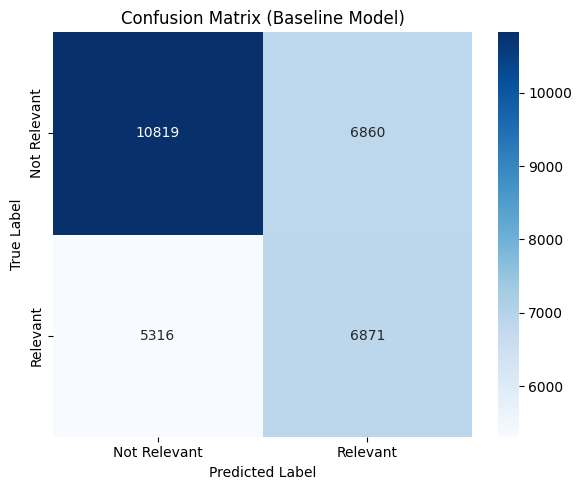

In [100]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)
labels = ["Not Relevant", "Relevant"]

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Baseline Model)")
plt.tight_layout()
plt.show()

In [106]:
print("check")

check


# Manual Inspection 

In [108]:
# Assume you have access to the original text dataset (not just tokenized), e.g., `dataset_test`
# And that preds and labels are already computed

# Add predictions and labels to the dataset
dataset_test_with_preds = dataset_test.add_column("pred", preds.tolist())
dataset_test_with_preds = dataset_test_with_preds.add_column("true", labels)

# Convert to pandas for easier filtering
df = dataset_test_with_preds.to_pandas()

# Show false positives (predicted relevant but actually not)
print("🔴 False Positives (pred=1, true=0):")
display(df[(df["pred"] == 1) & (df["true"] == 0)][["question", "context", "true", "pred"]].sample(5))

# Show false negatives (predicted not relevant but actually relevant)
print("🔵 False Negatives (pred=0, true=1):")
display(df[(df["pred"] == 0) & (df["true"] == 1)][["question", "context", "true", "pred"]].sample(5))


ValueError: Failed to concatenate on axis=1 because tables don't have the same number of rows